In [9]:
# Import libraries

import pylab as pl
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs

# pl.rcParams['figure.facecolor']='w'

from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
import matplotlib.pyplot as plt

import pyspeckit
import astropy.units as u
import astropy.wcs as wcs
import aplpy as aplpy
from astropy.io import fits

from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs import WCS

from astropy.coordinates import SkyCoord 
from astropy.wcs.utils import skycoord_to_pixel 
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib.patches import Ellipse


In [2]:
# Read all fits files

cube_N2Dp_lowres=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/N2Dp/HOPS164_N2Dp_large_sm_reb.fits')
cube_N2Dp_lowres = cube_N2Dp_lowres.to(u.K).with_spectral_unit(u.km/u.s)

cube_N2Dp=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/N2Dp/HOPS164_N2Dp_Tp12m7m_large_Combine_pbcor.fits')
cube_N2Dp = cube_N2Dp.to(u.K).with_spectral_unit(u.km/u.s)
cube_N2Dp_pvdiagram=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/N2Dp/HOPS164_N2Dp_Tp12m7m_large_Combine_pbcor.fits')

cube_H2CO=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/H2CO/HOPS164_H2CO_Tp12m7m_Combine_pbcor_masked.fits')
cube_H2CO = cube_H2CO.to(u.K).with_spectral_unit(u.km/u.s)
cube_H2CO_pvdiagram=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/H2CO/HOPS164_H2CO_Tp12m7m_Combine_pbcor_masked.fits')

cube_C18O=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/C18O/HOPS164_C18O_Tp12m7m_Combine_pbcor_masked.fits')
cube_C18O = cube_C18O.to(u.K).with_spectral_unit(u.km/u.s)
cube_C18O_pvdiagram=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/C18O/HOPS164_C18O_Tp12m7m_Combine_pbcor_masked.fits')

cube_13CO=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/13CO/HOPS164_13CO_Tp12m7m_Combine_pbcor_masked.fits')
cube_13CO = cube_13CO.to(u.K).with_spectral_unit(u.km/u.s)
cube_13CO_pvdiagram=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/13CO/HOPS164_13CO_Tp12m7m_Combine_pbcor_masked.fits')

cube_12CO=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/CO/HOPS164_CO_Tp12m7m_Combine_pbcor_masked.fits')
cube_12CO.allow_huge_operations = True 
cube_12CO = cube_12CO.to(u.K).with_spectral_unit(u.km/u.s)
cube_12CO_pvdiagram=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/CO/HOPS164_CO_Tp12m7m_Combine_pbcor_masked.fits')
cube_12CO_pvdiagram.allow_huge_operations = True 

# Continuum
fits_path = "/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/Continuum/HOPS-164_Continuum_natural_thres0.4mJy.pbcor.fits"
hdu = fits.open(fits_path)[0]  
wcs = WCS(hdu.header).celestial

In [3]:
# Define contour, path, and beam functions

def plot_contours(fits_file, color, min_level, max_level, number_of_levels, ax):

    gamma = 2.0
    scaled_levels = np.linspace(0, 1, number_of_levels) ** gamma
    levels_continuum = min_level + (max_level - min_level) * scaled_levels
    
    return ax.contour(fits_file, colors=color, levels=levels_continuum, linewidths=0.5)


def find_path2(data, y1, y2, y_iter, x1, x2):
    my_list = []

    for col in range(y1, y2, y_iter):
        valores = []

        for row in data[:, col]:

            for i in range(x1-x2):
                valores.append(i)
                max_value = np.nanmax(valores)
                indices = np.where(data == max_value)
                print(indices)
                i = (indices[1][0], indices[1][0])
                my_list.append(i)

    return print(my_list)

def find_path(data, y1, y2, y_iter, x1, x2):
    my_list = []

    for col in range(y1, y2, y_iter):
        valores = []

        # Grab the vertical slice of data in this column, between rows x1 and x2
        for row in range(x1, x2):
            value = data[row, col]
            valores.append(value)

        # Find the maximum value in the vertical slice
        max_value = np.nanmax(valores)

        # Find where it occurs in the full 2D array
        indices = np.where(data == max_value)
        i = (indices[0][0], indices[1][0])  # (row, col)
        my_list.append(i)

    print(my_list)

def beam(beam_minor, beam_major, beam_pa, beam_position):
    # Set beam location
    beam_x = beam_position  
    beam_y = beam_position

    # Create the beam ellipse
    return Ellipse(
        (beam_x, beam_y),
        width=beam_major,
        height=beam_minor,
        angle=beam_pa,
        edgecolor='black',
        facecolor='none',
        alpha=0.7,
        zorder=10
    )


In [4]:
# Actual coordinates for center of the protostar (Tobin et. al. 2020)
# marker_coord = SkyCoord("5h37m00.454s", "-6d37m10.48s", frame='icrs')

# Coordinates that work for ALMA
marker_coord = SkyCoord("5h37m00.4307s", "-6d37m10.7s", frame='icrs')
x_marker, y_marker = skycoord_to_pixel(marker_coord, cube_N2Dp.wcs.celestial)

# print(x_marker, y_marker)

# Perpendicular to Disk Emission

# N2D+ (high-res)

In [129]:
v_min_N2Dp = 4.0
v_max_N2Dp = 7.5

# Chose channels with emission
slab_N2Dp = cube_N2Dp.spectral_slab(v_min_N2Dp*u.km/u.s, v_max_N2Dp*u.km/u.s)
slab_N2Dp_pvdiagram = cube_N2Dp_pvdiagram.spectral_slab(v_min_N2Dp*u.km/u.s, v_max_N2Dp*u.km/u.s)

# Create moment 0 map
moment0 = slab_N2Dp.moment(order=0)

# Access moment 0 data
data_N2Dp = moment0.hdu.data

In [130]:
# Given center and position angle
center = np.array([228.5354, 220.0])  # (x, y)
PA = np.radians(151.02430954744995)  # Convert to radians
length = 280  # Adjust as needed

# Compute endpoint offsets along the major axis
dx = (length / 2) * np.cos(PA)
dy = (length / 2) * np.sin(PA)

# Define extended path endpoints
point1 = center + np.array([-dx, -dy])
point2 = center + np.array([dx, dy])

# Create and plot the path
path_perpendicular_to_disk = Path([point1, point2], width=0.5)

Setting the 'color' property will override the edgecolor or facecolor properties.


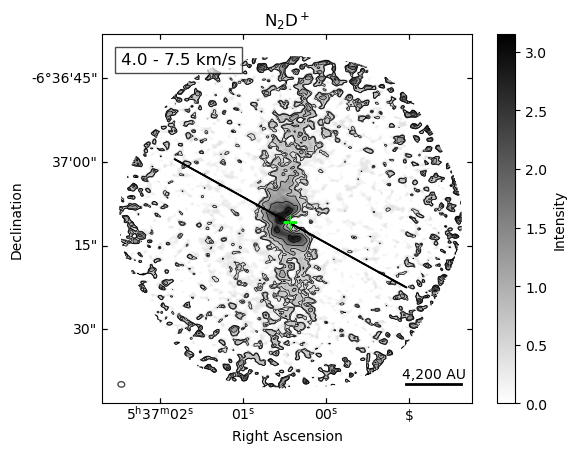

In [131]:
fig = plt.figure()
ax = pl.plt.subplot(111, projection=cube_N2Dp.wcs.celestial)
im = ax.imshow(data_N2Dp, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_N2Dp, color='black', min_level=0.4, max_level=2.5, number_of_levels=5, ax=ax)

# Plot the protostar marker
ax.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(r'N$_2$D$^+$')

# Add velocity label in the top left of the subplot
ax.text(0.05, 0.95, f"{v_min_N2Dp:.1f} - {v_max_N2Dp:.1f} km/s", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add it to the plot
beam_N2Dp = beam(1.22/0.17, 0.98/0.17, 84.98, 50) #beam arcseconds times pixel arcseconds for the fits file
ax.add_patch(beam_N2Dp)

# Set offset limits
ax.set_xlim(30, 420) 
ax.set_ylim(30, 420)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 320    
y_start = ax.get_ylim()[0] + 20  

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

path_perpendicular_to_disk.show_on_axis(ax, spacing=1, color='black')

# Save image
# plt.savefig("HOPS164_N2Dp_contour_map_with_pvdiagram_path.png", format="png", dpi=300, bbox_inches="tight")

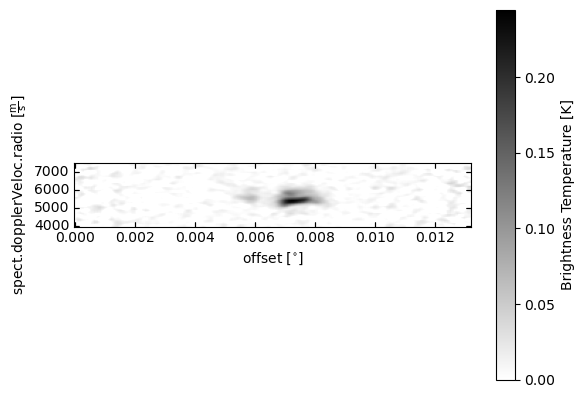

In [132]:
N2Dp_pvdiagram = extract_pv_slice(slab_N2Dp_pvdiagram, path_perpendicular_to_disk, spacing=1) 

ax=pl.plt.axes(111,projection=wcs.WCS(N2Dp_pvdiagram.header))
im=ax.imshow(N2Dp_pvdiagram.data, cmap='binary', vmin=0)
cb=pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

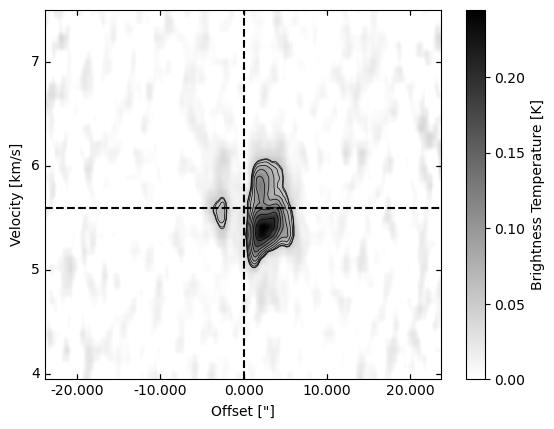

In [133]:
# Get the data array from the PV diagram
data = N2Dp_pvdiagram.data
ny, nx = data.shape

# Define offset and velocity axes
x_axis = np.arange(data.shape[1])  # Offset in pixels
y_axis = np.linspace(v_min_N2Dp, v_max_N2Dp, data.shape[0])  # Velocity in km/s

# Center of the offset axis (pixel 145 = 0 arcsec)
center_index = 140 # center of pvdiagram

# Update WCS header to match that center
pv_header_centered = N2Dp_pvdiagram.header.copy()
pv_header_centered['CRPIX1'] = center_index + 1  # 1-based FITS indexing
pv_header_centered['CRVAL1'] = 0.0  # Center at 0 arcsec

ww = wcs.WCS(pv_header_centered)

# Plot
ax = pl.plt.axes(111, projection=ww)
im = ax.imshow(N2Dp_pvdiagram.data, aspect='auto', cmap='binary', vmin=0)
cb = pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax.set_ylabel('Velocity [km/s]')
ax.set_xlabel('Offset ["]')
ax.tick_params(axis='both', direction='in', which='both')

plot_contours(N2Dp_pvdiagram.data, 'black', 0.05, 0.2, 9, ax)

# Add guide lines
x0_pix = nx / 2
ax.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000 # kilometers
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')


Setting the 'color' property will override the edgecolor or facecolor properties.


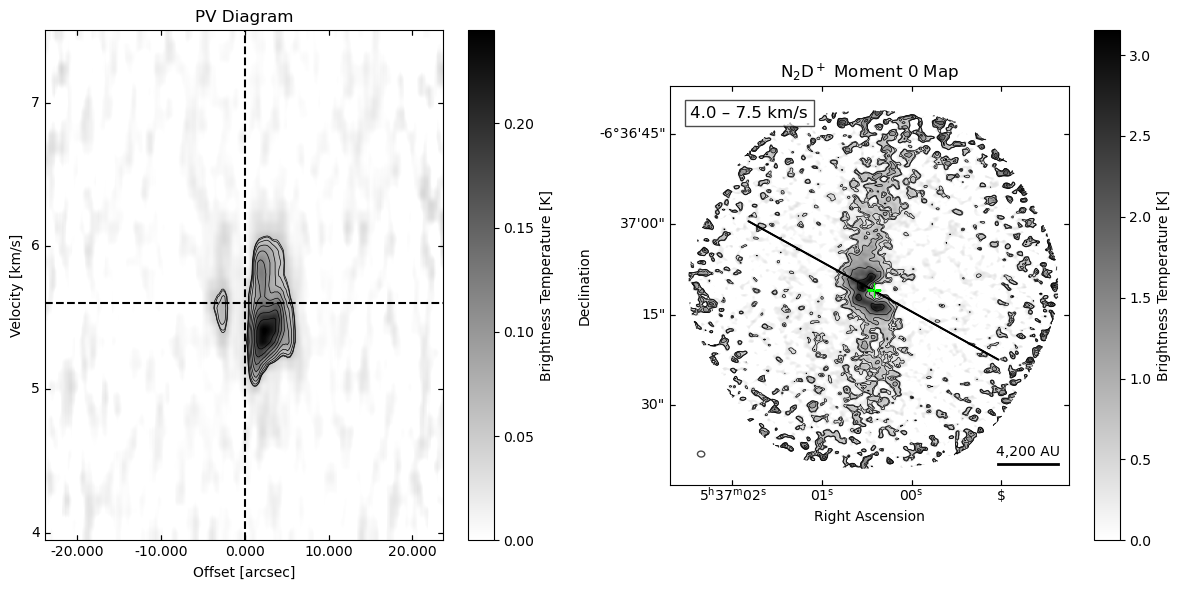

In [134]:
fig = plt.figure(figsize=(12, 6))

# === PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(N2Dp_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax0 = ax1.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax00 = ax1.coords[1]
ax00.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

cb1 = plt.colorbar(im1, ax=ax1)
cb1.set_label('Brightness Temperature [K]')

plot_contours(N2Dp_pvdiagram.data, 'black', 0.05, 0.2, 9, ax1)

# === Moment 0 Map (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=cube_N2Dp_pvdiagram.wcs.celestial)
im2 = ax2.imshow(data_N2Dp, origin='lower', cmap='binary', vmin=0)
ax2.tick_params(axis='both', direction='in', which='both')

# Add guide lines
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Colorbar
cb2 = plt.colorbar(im2, ax=ax2)
cb2.set_label('Brightness Temperature [K]')

# Plot contours on ax2
plot_contours(data_N2Dp, color='black', min_level=0.4, max_level=2.5, number_of_levels=5, ax=ax2)

# Labels
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
ax2.set_title(r'N$_2$D$^+$ Moment 0 Map')

# Add velocity label
ax2.text(0.05, 0.95, f"{v_min_N2Dp:.1f} – {v_max_N2Dp:.1f} km/s", transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add beam
beam_N2Dp = beam(1.22/0.17, 0.98/0.17, 84.98, 60)  # use actual beam if available
ax2.add_patch(beam_N2Dp)

# Set limits (adjust as needed based on real image size)
ax2.set_xlim(30, 420) 
ax2.set_ylim(30, 420)

# Scale bar setup
scale_bar_length_pix = 10 / 0.17  # pixels for 10 arcsec
x_start = ax2.get_xlim()[0] + 320    
y_start = ax2.get_ylim()[0] + 20  

ax2.plot([x_start, x_start + scale_bar_length_pix], [y_start, y_start], color='black', linewidth=2)
ax2.text(x_start + scale_bar_length_pix / 2, y_start + 5, "4,200 AU", color='black', ha='center', va='bottom', fontsize=10)

# Path overlay
path_perpendicular_to_disk.show_on_axis(ax2, spacing=1, color='black')

# Plot marker
ax2.plot(229, 220, marker='+', color='lime', markersize=10, label='Marker')

plt.tight_layout()
plt.show()


# H2CO

In [135]:
# Chose channels with emission
v_min_H2CO = 4.0
v_max_H2CO = 7.5
slab_H2CO = cube_H2CO.spectral_slab(v_min_H2CO*u.km/u.s, v_max_H2CO*u.km/u.s)
slab_H2CO_pvdiagram = cube_H2CO_pvdiagram.spectral_slab(v_min_H2CO*u.km/u.s, v_max_H2CO*u.km/u.s)

# Create moment 0 map
moment0 = slab_H2CO.moment(order=0)

# Access moment 0 data
data_H2CO = moment0.hdu.data

Setting the 'color' property will override the edgecolor or facecolor properties.


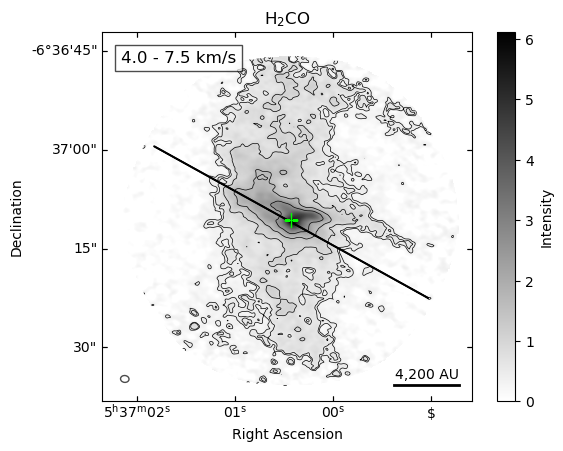

In [136]:
fig = plt.figure()
ax = pl.plt.subplot(111, projection=cube_H2CO.wcs.celestial)
im = ax.imshow(data_H2CO, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_H2CO, color='black', min_level=0.4, max_level=2.5, number_of_levels=5, ax=ax)

# Plot the protostar marker
ax.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(r'H$_2$CO')

# Add velocity label in the top left of the subplot
ax.text(0.05, 0.95, f"{v_min_H2CO:.1f} - {v_max_H2CO:.1f} km/s", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add it to the plot
beam_H2CO = beam(1.29/0.17, 1.04/0.17, 83.63, 80) #beam arcseconds times pixel arcseconds for the fits file
ax.add_patch(beam_H2CO)

# Set offset limits
ax.set_xlim(60, 390) 
ax.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 260
y_start = ax.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

path_perpendicular_to_disk.show_on_axis(ax, spacing=1, color='black')

# Save image
# plt.savefig("HOPS164_H2CO_contour_map_with_pvdiagram_path.png", format="png", dpi=300, bbox_inches="tight")

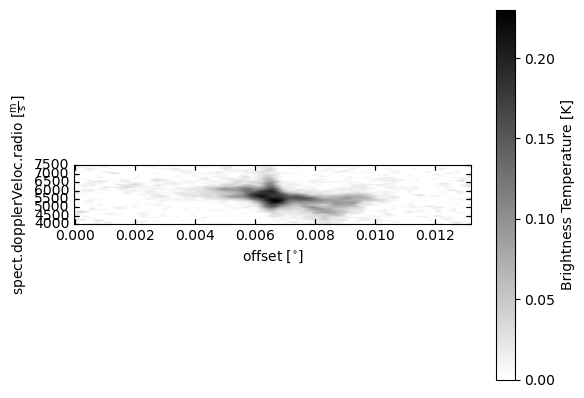

In [137]:
H2CO_pvdiagram = extract_pv_slice(slab_H2CO_pvdiagram, path_perpendicular_to_disk, spacing=1) 

ax=pl.plt.axes(111,projection=wcs.WCS(H2CO_pvdiagram.header))
im=ax.imshow(H2CO_pvdiagram.data, cmap='binary', vmin=0)
cb=pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

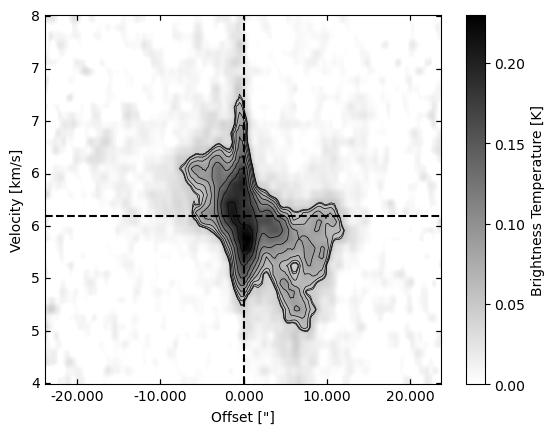

In [138]:
# Get the data array from the PV diagram
data = H2CO_pvdiagram.data
ny, nx = data.shape

# Define offset and velocity axes
x_axis = np.arange(data.shape[1])  # Offset in pixels
y_axis = np.linspace(v_min_H2CO, v_max_H2CO, data.shape[0])  # Velocity in km/s

# Center of the offset axis (pixel 145 = 0 arcsec)
center_index = 140 # center of pvdiagram

# Update WCS header to match that center
pv_header_centered = H2CO_pvdiagram.header.copy()
pv_header_centered['CRPIX1'] = center_index + 1  # 1-based FITS indexing
pv_header_centered['CRVAL1'] = 0.0  # Center at 0 arcsec

ww = wcs.WCS(pv_header_centered)

# Plot
ax = pl.plt.axes(111, projection=ww)
im = ax.imshow(H2CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0)
cb = pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax.set_ylabel('Velocity [km/s]')
ax.set_xlabel('Offset ["]')
ax.tick_params(axis='both', direction='in', which='both')

plot_contours(H2CO_pvdiagram.data, 'black', 0.05, 0.2, 9, ax=ax)

# Add guide lines
x0_pix = nx / 2
ax.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000 # kilometers
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')


Setting the 'color' property will override the edgecolor or facecolor properties.


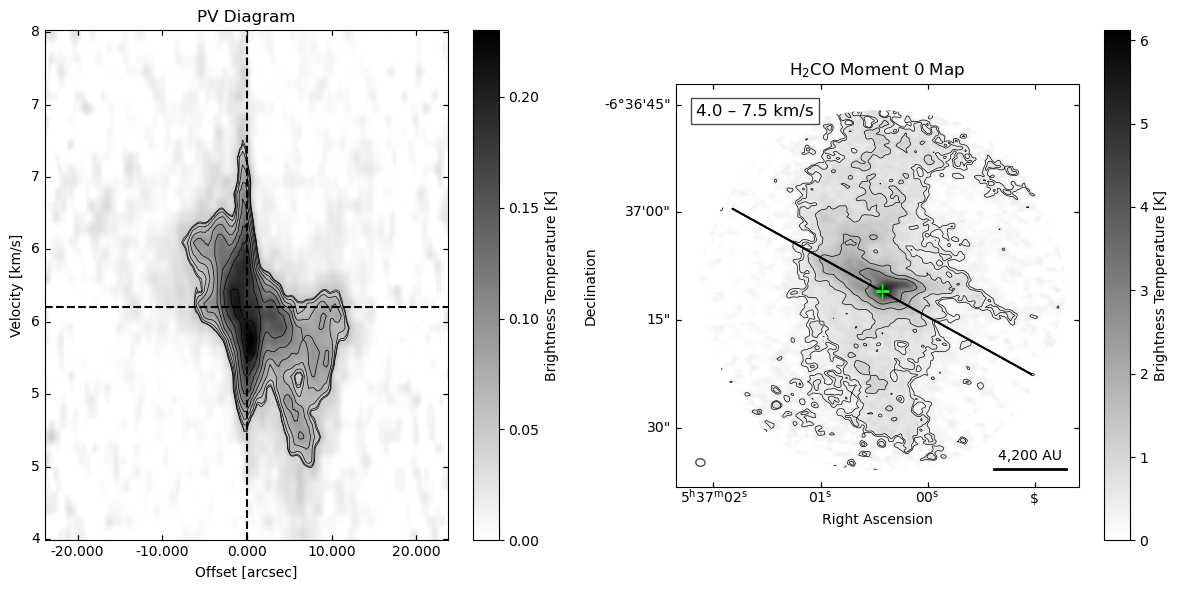

In [139]:
fig = plt.figure(figsize=(12, 6))

# === PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(H2CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax0 = ax1.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax00 = ax1.coords[1]
ax00.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

cb1 = plt.colorbar(im1, ax=ax1)
cb1.set_label('Brightness Temperature [K]')

plot_contours(H2CO_pvdiagram.data, 'black', 0.05, 0.2, 9, ax1)

# === Moment 0 Map (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=cube_H2CO_pvdiagram.wcs.celestial)
im2 = ax2.imshow(data_H2CO, origin='lower', cmap='binary', vmin=0)
ax2.tick_params(axis='both', direction='in', which='both')

# Add guide lines
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Colorbar
cb2 = plt.colorbar(im2, ax=ax2)
cb2.set_label('Brightness Temperature [K]')

# Plot contours on ax2
plot_contours(data_H2CO, color='black', min_level=0.4, max_level=2.5, number_of_levels=5, ax=ax2)

# Labels
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
ax2.set_title(r'H$_2$CO Moment 0 Map')

# Add velocity label
ax2.text(0.05, 0.95, f"{v_min_H2CO:.1f} – {v_max_H2CO:.1f} km/s", transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add beam
beam_H2CO = beam(1.29/0.17, 1.04/0.17, 83.63, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_H2CO)

# Set limits (adjust as needed based on real image size)
ax2.set_xlim(60, 390) 
ax2.set_ylim(60, 390)

# Scale bar setup
scale_bar_length_pix = 10 / 0.17  # pixels for 10 arcsec
x_start = ax2.get_xlim()[0] + 260  
y_start = ax2.get_ylim()[0] + 15

ax2.plot([x_start, x_start + scale_bar_length_pix], [y_start, y_start], color='black', linewidth=2)
ax2.text(x_start + scale_bar_length_pix / 2, y_start + 5, "4,200 AU", color='black', ha='center', va='bottom', fontsize=10)

# Path overlay
path_perpendicular_to_disk.show_on_axis(ax2, spacing=1, color='black')

# Plot marker
ax2.plot(229, 220, marker='+', color='lime', markersize=10, label='Marker')

plt.tight_layout()
plt.show()

# C18O

In [140]:
# Chose channels with emission
v_min_C18O = 4.0
v_max_C18O = 7.5
slab_C18O = cube_C18O.spectral_slab(v_min_C18O*u.km/u.s, v_max_C18O*u.km/u.s)
slab_C18O_pvdiagram = cube_C18O_pvdiagram.spectral_slab(v_min_C18O*u.km/u.s, v_max_C18O*u.km/u.s)

# Create moment 0 map
moment0 = slab_C18O.moment(order=0)

# Access moment 0 data
data_C18O = moment0.hdu.data

Setting the 'color' property will override the edgecolor or facecolor properties.


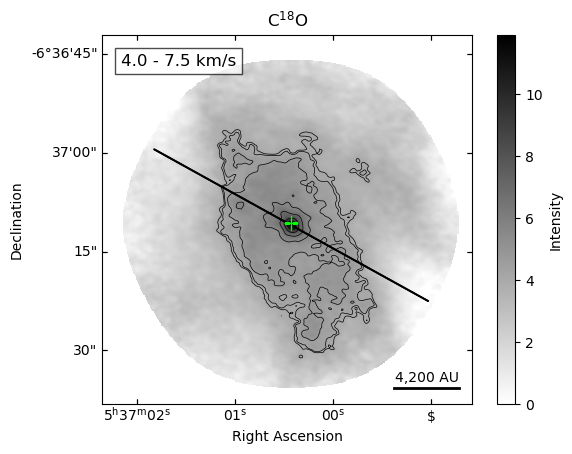

In [141]:
fig = plt.figure()
ax = pl.plt.subplot(111, projection=cube_C18O.wcs.celestial)
im = ax.imshow(data_C18O, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_C18O, color='black', min_level=4, max_level=15, number_of_levels=9, ax=ax)

# Plot the protostar marker
ax.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(r'C$^{18}$O')

# Add velocity label in the top left of the subplot
ax.text(0.05, 0.95, f"{v_min_C18O:.1f} - {v_max_C18O:.1f} km/s", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add beam
beam_C18O = beam(1.30/0.17, 1.03/0.17, 85.77, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_C18O)

# Set offset limits
ax.set_xlim(60, 390) 
ax.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 260
y_start = ax.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

path_perpendicular_to_disk.show_on_axis(ax, spacing=1, color='black')

# Save image
# plt.savefig("HOPS164_C18O_contour_map_with_pvdiagram_path.png", format="png", dpi=300, bbox_inches="tight")

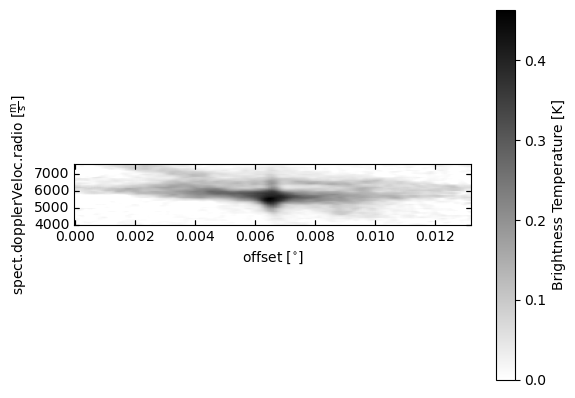

In [142]:
C18O_pvdiagram = extract_pv_slice(slab_C18O_pvdiagram, path_perpendicular_to_disk, spacing=1) 

ax=pl.plt.axes(111,projection=wcs.WCS(C18O_pvdiagram.header))
im=ax.imshow(C18O_pvdiagram.data, cmap='binary', vmin=0)
cb=pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

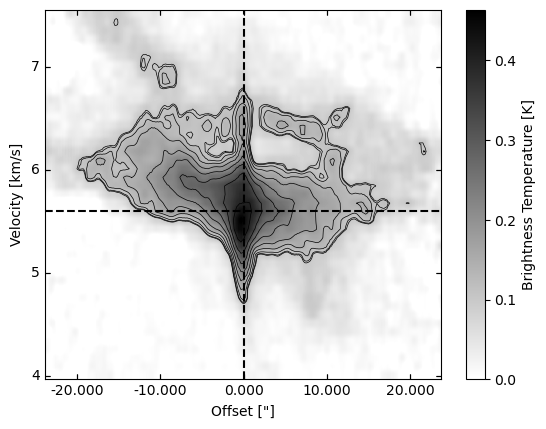

In [143]:
# Get the data array from the PV diagram
data = C18O_pvdiagram.data
ny, nx = data.shape

# Define offset and velocity axes
x_axis = np.arange(data.shape[1])  # Offset in pixels
y_axis = np.linspace(v_min_C18O, v_max_C18O, data.shape[0])  # Velocity in km/s

# Center of the offset axis (pixel 145 = 0 arcsec)
center_index = 140 # center of pvdiagram

# Update WCS header to match that center
pv_header_centered = C18O_pvdiagram.header.copy()
pv_header_centered['CRPIX1'] = center_index + 1  # 1-based FITS indexing
pv_header_centered['CRVAL1'] = 0.0  # Center at 0 arcsec

ww = wcs.WCS(pv_header_centered)

# Plot
ax = pl.plt.axes(111, projection=ww)
im = ax.imshow(C18O_pvdiagram.data, aspect='auto', cmap='binary', vmin=0)
cb = pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax.set_ylabel('Velocity [km/s]')
ax.set_xlabel('Offset ["]')
ax.tick_params(axis='both', direction='in', which='both')

plot_contours(C18O_pvdiagram.data, 'black', 0.1, 0.4, 9, ax=ax)

# Add guide lines
x0_pix = nx / 2
ax.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000 # kilometers
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

Setting the 'color' property will override the edgecolor or facecolor properties.


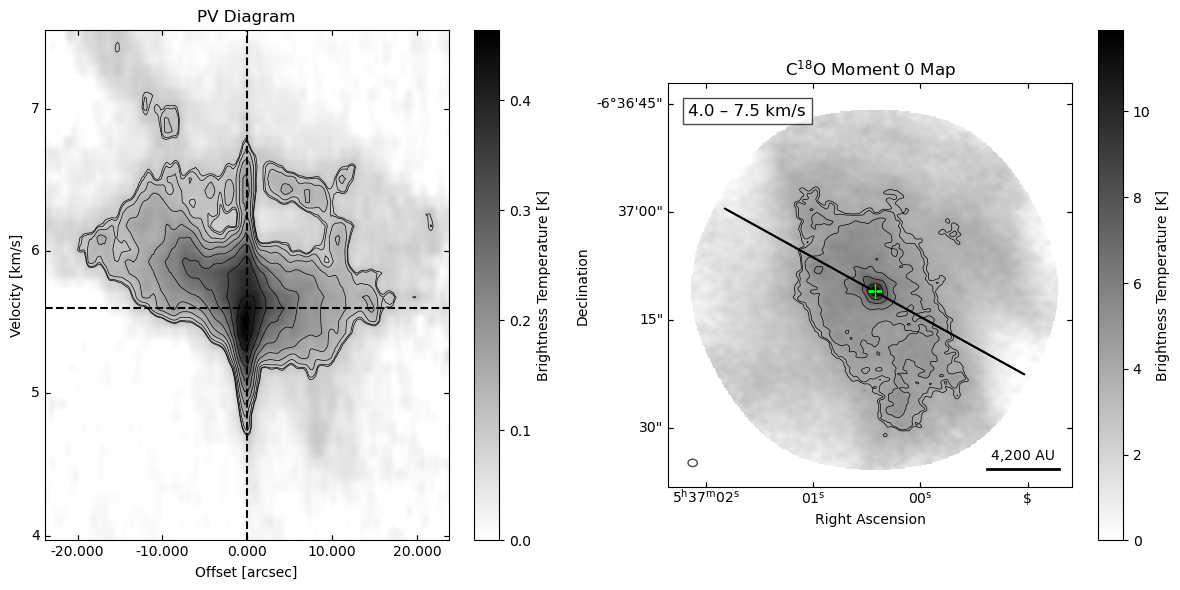

In [144]:
fig = plt.figure(figsize=(12, 6))

# === PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(C18O_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax0 = ax1.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax00 = ax1.coords[1]
ax00.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

cb1 = plt.colorbar(im1, ax=ax1)
cb1.set_label('Brightness Temperature [K]')

plot_contours(C18O_pvdiagram.data, 'black', 0.1, 0.4, 9, ax=ax1)

# === Moment 0 Map (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=cube_C18O_pvdiagram.wcs.celestial)
im2 = ax2.imshow(data_C18O, origin='lower', cmap='binary', vmin=0)
ax2.tick_params(axis='both', direction='in', which='both')

# Add guide lines
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Colorbar
cb2 = plt.colorbar(im2, ax=ax2)
cb2.set_label('Brightness Temperature [K]')

# Plot contours on ax2
plot_contours(data_C18O, color='black', min_level=4, max_level=15, number_of_levels=9, ax=ax2)

# Labels
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
ax2.set_title(r'C$^{18}$O Moment 0 Map')

# Add velocity label
ax2.text(0.05, 0.95, f"{v_min_C18O:.1f} – {v_max_C18O:.1f} km/s", transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add beam
beam_C18O = beam(1.30/0.17, 1.03/0.17, 85.77, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_C18O)

# Set limits (adjust as needed based on real image size)
ax2.set_xlim(60, 390) 
ax2.set_ylim(60, 390)

# Scale bar setup
scale_bar_length_pix = 10 / 0.17  # pixels for 10 arcsec
x_start = ax2.get_xlim()[0] + 260  
y_start = ax2.get_ylim()[0] + 15

ax2.plot([x_start, x_start + scale_bar_length_pix], [y_start, y_start], color='black', linewidth=2)
ax2.text(x_start + scale_bar_length_pix / 2, y_start + 5, "4,200 AU", color='black', ha='center', va='bottom', fontsize=10)

# Path overlay
path_perpendicular_to_disk.show_on_axis(ax2, spacing=1, color='black')

# Plot marker
ax2.plot(229, 220, marker='+', color='lime', markersize=10, label='Marker')

plt.tight_layout()
plt.show()

# 12CO

In [145]:
# Chose channels with emission
v_min_12CO = 10.0
v_max_12CO = 1.0
slab_12CO = cube_12CO.spectral_slab(v_min_12CO*u.km/u.s, v_max_12CO*u.km/u.s)
slab_12CO_pvdiagram = cube_12CO_pvdiagram.spectral_slab(v_min_12CO*u.km/u.s, v_max_12CO*u.km/u.s)

# Create moment 0 map
moment0 = slab_12CO.moment(order=0)

# Access moment 0 data
data_12CO = moment0.hdu.data

Setting the 'color' property will override the edgecolor or facecolor properties.


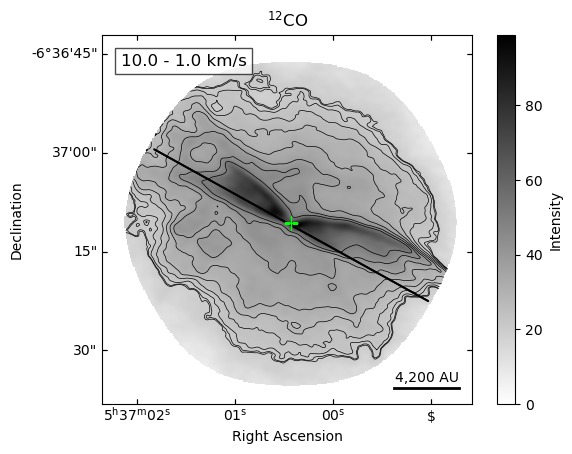

In [146]:
fig = plt.figure()
ax = pl.plt.subplot(111, projection=cube_12CO.wcs.celestial)
im = ax.imshow(data_12CO, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_12CO, color='black', min_level=20, max_level=50, number_of_levels=9, ax=ax)

# Plot the protostar marker
ax.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(r'$^{12}$CO')

# Add velocity label in the top left of the subplot
ax.text(0.05, 0.95, f"{v_min_12CO:.1f} - {v_max_12CO:.1f} km/s", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add beam
beam_12CO = beam(1.25/0.17, 0.98/0.17, 84.20, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_12CO)

# Set offset limits
ax.set_xlim(60, 390) 
ax.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 260
y_start = ax.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

path_perpendicular_to_disk.show_on_axis(ax, spacing=1, color='black')

# Save image
# plt.savefig("HOPS164_12CO_contour_map_with_pvdiagram_path.png", format="png", dpi=300, bbox_inches="tight")

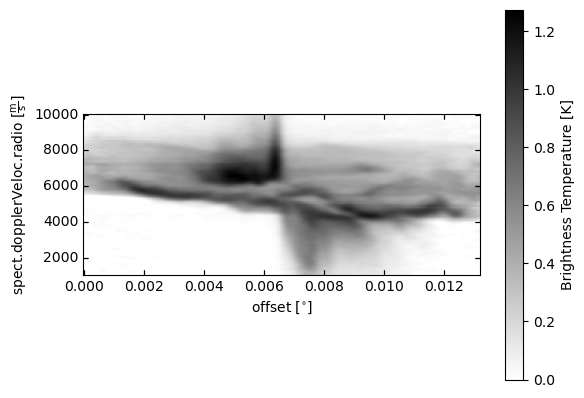

In [147]:
CO_pvdiagram = extract_pv_slice(slab_12CO_pvdiagram, path_perpendicular_to_disk, spacing=1) 

ax=pl.plt.axes(111,projection=wcs.WCS(CO_pvdiagram.header))
im=ax.imshow(CO_pvdiagram.data, cmap='binary', vmin=0)
cb=pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

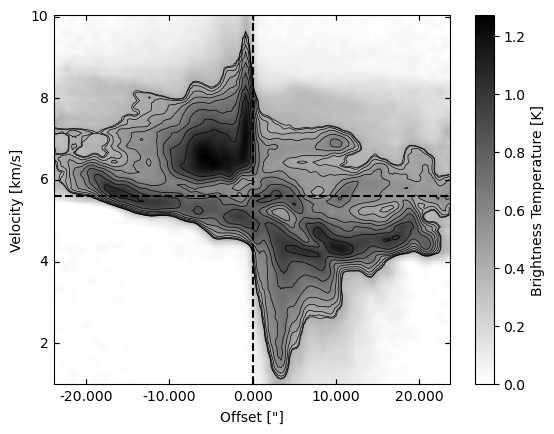

In [151]:
# Get the data array from the PV diagram
data = CO_pvdiagram.data
CO_ny, CO_nx = data.shape

# Center of the offset axis (pixel 145 = 0 arcsec)
center_index = 140 # center of pvdiagram

# Update WCS header to match that center
pv_header_centered = CO_pvdiagram.header.copy()
pv_header_centered['CRPIX1'] = center_index + 1  # 1-based FITS indexing
pv_header_centered['CRVAL1'] = 0.0  # Center at 0 arcsec

CO_ww = wcs.WCS(pv_header_centered)

# Plot
ax = pl.plt.axes(111, projection=CO_ww)
im = ax.imshow(CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0)
cb = pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax.set_ylabel('Velocity [km/s]')
ax.set_xlabel('Offset ["]')
ax.tick_params(axis='both', direction='in', which='both')

plot_contours(CO_pvdiagram.data, 'black', 0.4, 1.0, 9, ax=ax)

# Add guide lines
CO_x0_pix = CO_nx / 2 
ax.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000 # kilometers
CO_x_center = CO_nx // 2
CO_y56_pix = CO_ww.wcs_world2pix([[CO_ww.wcs_pix2world([[CO_x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax.axhline(y=CO_y56_pix, color='black', linestyle='--', label='5.6 km/s')

Setting the 'color' property will override the edgecolor or facecolor properties.


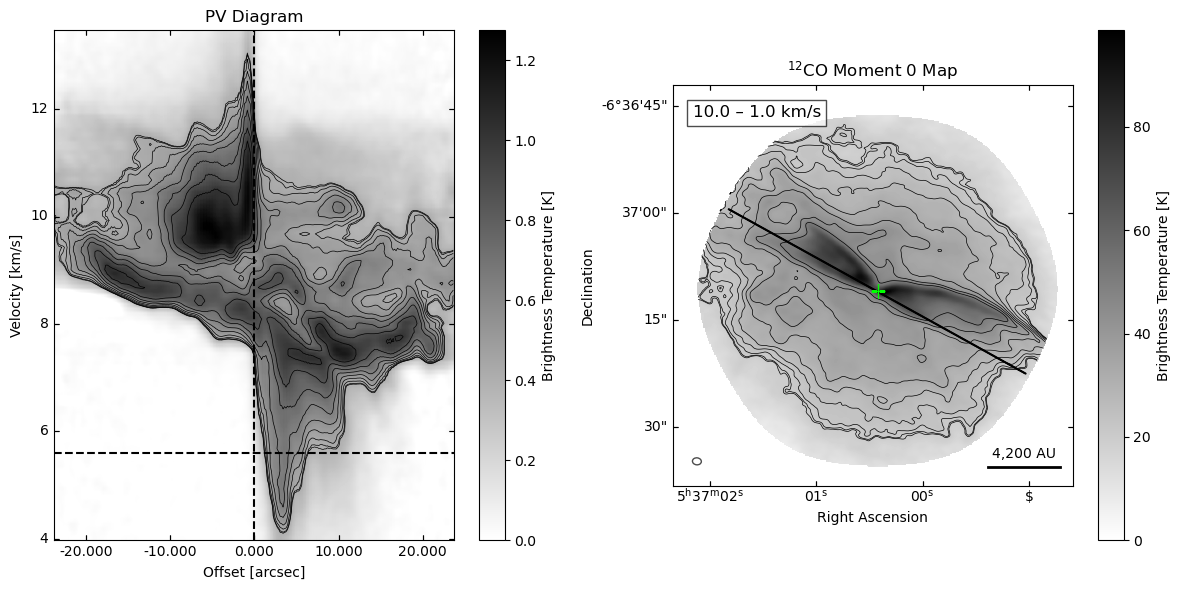

In [149]:
fig = plt.figure(figsize=(12, 6))

# === PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax0 = ax1.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax00 = ax1.coords[1]
ax00.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

cb1 = plt.colorbar(im1, ax=ax1)
cb1.set_label('Brightness Temperature [K]')

plot_contours(CO_pvdiagram.data, 'black', 0.4, 1.0, 9, ax=ax1)

# === Moment 0 Map (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=cube_12CO_pvdiagram.wcs.celestial)
im2 = ax2.imshow(data_12CO, origin='lower', cmap='binary', vmin=0)
ax2.tick_params(axis='both', direction='in', which='both')

# Add guide lines
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Colorbar
cb2 = plt.colorbar(im2, ax=ax2)
cb2.set_label('Brightness Temperature [K]')

# Plot contours on ax2
plot_contours(data_12CO, color='black', min_level=20, max_level=50, number_of_levels=9, ax=ax2)

# Labels
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
ax2.set_title(r'$^{12}$CO Moment 0 Map')

# Add velocity label
ax2.text(0.05, 0.95, f"{v_min_12CO:.1f} – {v_max_12CO:.1f} km/s", transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add beam
beam_12CO = beam(1.25/0.17, 0.98/0.17, 84.20, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_12CO)

# Set limits (adjust as needed based on real image size)
ax2.set_xlim(60, 390) 
ax2.set_ylim(60, 390)

# Scale bar setup
scale_bar_length_pix = 10 / 0.17  # pixels for 10 arcsec
x_start = ax2.get_xlim()[0] + 260  
y_start = ax2.get_ylim()[0] + 15

ax2.plot([x_start, x_start + scale_bar_length_pix], [y_start, y_start], color='black', linewidth=2)
ax2.text(x_start + scale_bar_length_pix / 2, y_start + 5, "4,200 AU", color='black', ha='center', va='bottom', fontsize=10)

# Path overlay
path_perpendicular_to_disk.show_on_axis(ax2, spacing=1, color='black')

# Plot marker
ax2.plot(229, 220, marker='+', color='lime', markersize=10, label='Marker')

plt.tight_layout()
plt.show()

# 13CO

In [118]:
# Chose channels with emission
v_min_13CO = 4.0
v_max_13CO = 7.5
slab_13CO = cube_13CO.spectral_slab(v_min_13CO*u.km/u.s, v_max_13CO*u.km/u.s)
slab_13CO_pvdiagram = cube_13CO_pvdiagram.spectral_slab(v_min_13CO*u.km/u.s, v_max_13CO*u.km/u.s)

# Create moment 0 map
moment0 = slab_13CO.moment(order=0)

# Access moment 0 data
data_13CO = moment0.hdu.data

Setting the 'color' property will override the edgecolor or facecolor properties.


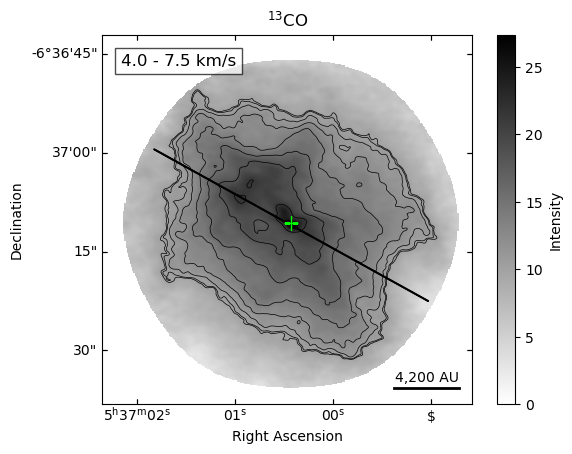

In [119]:
fig = plt.figure()
ax = pl.plt.subplot(111, projection=cube_13CO.wcs.celestial)
im = ax.imshow(data_13CO, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_13CO, color='black', min_level=10, max_level=25, number_of_levels=9, ax=ax)

# Plot the protostar marker
ax.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(r'$^{13}$CO')

# Add velocity label in the top left of the subplot
ax.text(0.05, 0.95, f"{v_min_13CO:.1f} - {v_max_13CO:.1f} km/s", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add beam
beam_13CO = beam(1.29/0.17, 1.03/0.17, 84.42, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_13CO)

# Set offset limits
ax.set_xlim(60, 390) 
ax.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 260
y_start = ax.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

path_perpendicular_to_disk.show_on_axis(ax, spacing=1, color='black')

# Save image
# plt.savefig("HOPS164_13CO_contour_map_with_pvdiagram_path.png", format="png", dpi=300, bbox_inches="tight")

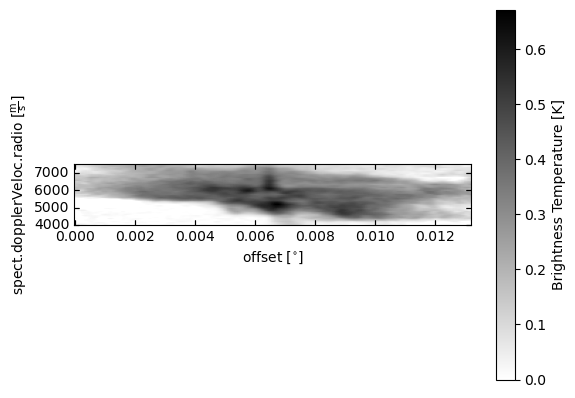

In [120]:
s13CO_pvdiagram = extract_pv_slice(slab_13CO_pvdiagram, path_perpendicular_to_disk, spacing=1) 

ax=pl.plt.axes(111,projection=wcs.WCS(s13CO_pvdiagram.header))
im=ax.imshow(s13CO_pvdiagram.data, cmap='binary', vmin=0)
cb=pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

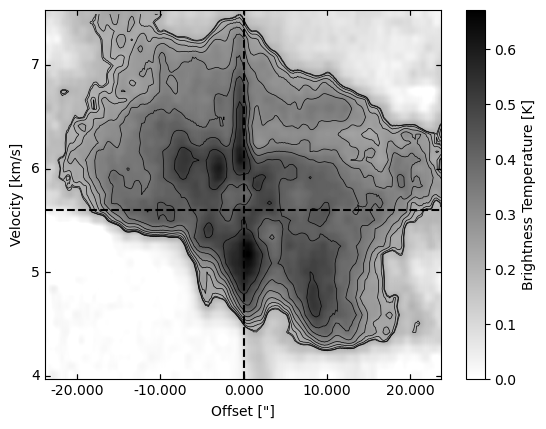

In [121]:
# Get the data array from the PV diagram
data = s13CO_pvdiagram.data
ny, nx = data.shape

# Define offset and velocity axes
x_axis = np.arange(data.shape[1])  # Offset in pixels
y_axis = np.linspace(v_min_13CO, v_max_13CO, data.shape[0])  # Velocity in km/s

# Center of the offset axis (pixel 145 = 0 arcsec)
center_index = 140 # center of pvdiagram

# Update WCS header to match that center
pv_header_centered = s13CO_pvdiagram.header.copy()
pv_header_centered['CRPIX1'] = center_index + 1  # 1-based FITS indexing
pv_header_centered['CRVAL1'] = 0.0  # Center at 0 arcsec

ww = wcs.WCS(pv_header_centered)

# Plot
ax = pl.plt.axes(111, projection=ww)
im = ax.imshow(s13CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0)
cb = pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax.set_ylabel('Velocity [km/s]')
ax.set_xlabel('Offset ["]')
ax.tick_params(axis='both', direction='in', which='both')

plot_contours(s13CO_pvdiagram.data, 'black', 0.2, 0.5, 9, ax=ax)

# Add guide lines
x0_pix = nx / 2
ax.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000 # kilometers
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

Setting the 'color' property will override the edgecolor or facecolor properties.


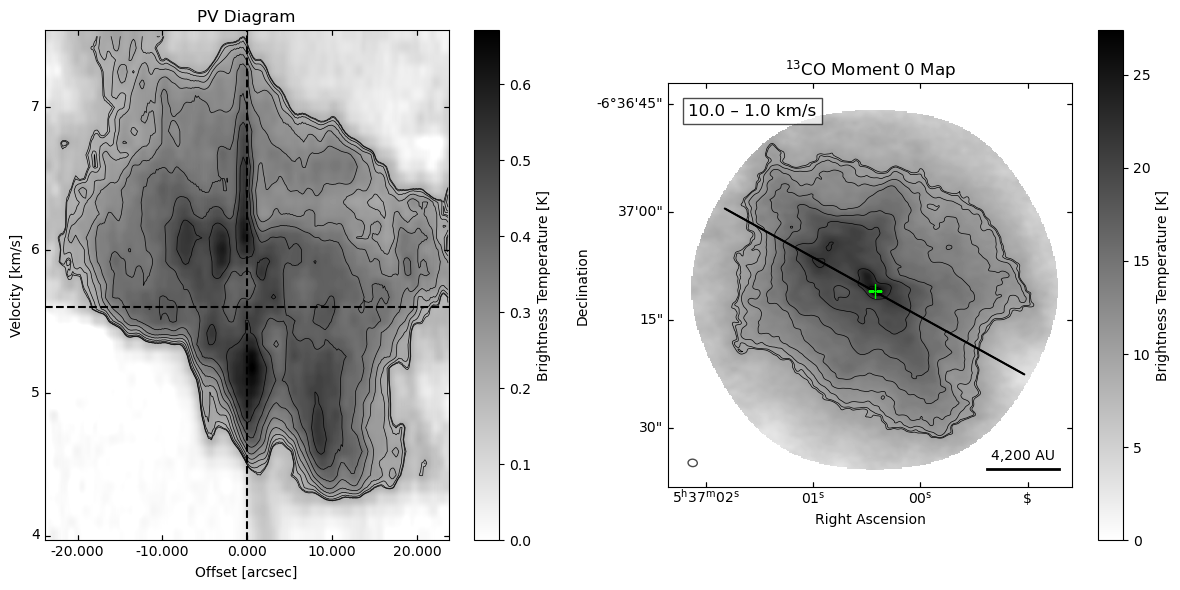

In [122]:
fig = plt.figure(figsize=(12, 6))

# === PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(s13CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax0 = ax1.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax00 = ax1.coords[1]
ax00.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

cb1 = plt.colorbar(im1, ax=ax1)
cb1.set_label('Brightness Temperature [K]')

plot_contours(s13CO_pvdiagram.data, 'black', 0.2, 0.5, 9, ax=ax1)

# === Moment 0 Map (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=cube_12CO_pvdiagram.wcs.celestial)
im2 = ax2.imshow(data_13CO, origin='lower', cmap='binary', vmin=0)
ax2.tick_params(axis='both', direction='in', which='both')

# Add guide lines
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Colorbar
cb2 = plt.colorbar(im2, ax=ax2)
cb2.set_label('Brightness Temperature [K]')

# Plot contours on ax2
plot_contours(data_13CO, color='black', min_level=10, max_level=25, number_of_levels=9, ax=ax2)

# Labels
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
ax2.set_title(r'$^{13}$CO Moment 0 Map')

# Add velocity label
ax2.text(0.05, 0.95, f"{v_min_12CO:.1f} – {v_max_12CO:.1f} km/s", transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add beam
beam_13CO = beam(1.29/0.17, 1.03/0.17, 84.42, 80) #beam arcseconds times pixel arcseconds for the fits file
ax2.add_patch(beam_13CO)

# Set limits (adjust as needed based on real image size)
ax2.set_xlim(60, 390) 
ax2.set_ylim(60, 390)

# Scale bar setup
scale_bar_length_pix = 10 / 0.17  # pixels for 10 arcsec
x_start = ax2.get_xlim()[0] + 260  
y_start = ax2.get_ylim()[0] + 15

ax2.plot([x_start, x_start + scale_bar_length_pix], [y_start, y_start], color='black', linewidth=2)
ax2.text(x_start + scale_bar_length_pix / 2, y_start + 5, "4,200 AU", color='black', ha='center', va='bottom', fontsize=10)

# Path overlay
path_perpendicular_to_disk.show_on_axis(ax2, spacing=1, color='black')

# Plot marker
ax2.plot(229, 220, marker='+', color='lime', markersize=10, label='Marker')

plt.tight_layout()
plt.show()

# All PVdiagrams together

In [123]:
# Helper function
def add_panel_label(ax, label, x=0.02, y=0.95):
    ax.text(x, y, f'({label})', transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')

Setting the 'color' property will override the edgecolor or facecolor properties.


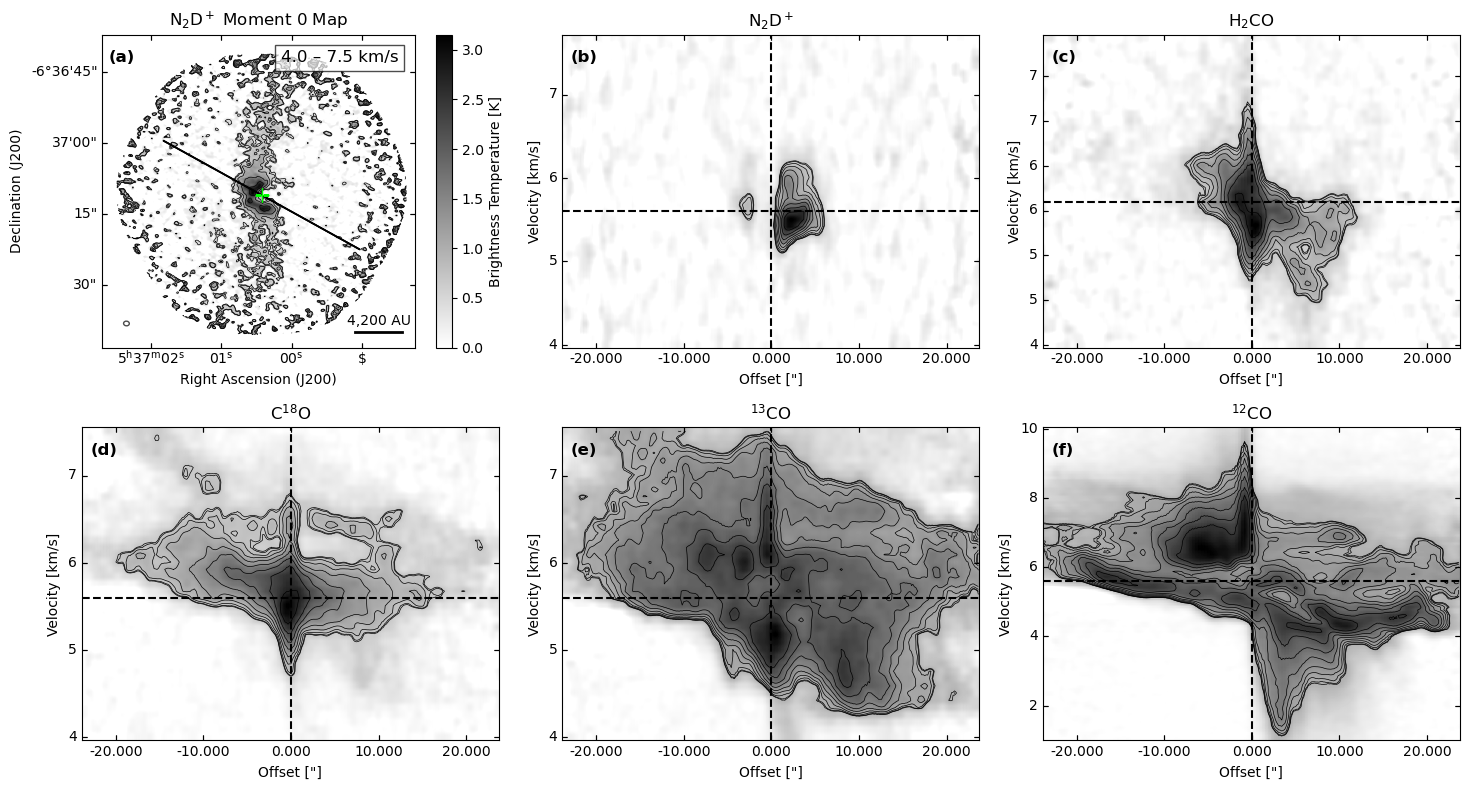

In [ ]:
fig = plt.figure(figsize=(15, 8))

ax0 = fig.add_subplot(2, 3, 1, projection=cube_N2Dp_pvdiagram.wcs.celestial)
ax1 = fig.add_subplot(2, 3, 2, projection=ww)
ax2 = fig.add_subplot(2, 3, 3, projection=ww)
ax3 = fig.add_subplot(2, 3, 4, projection=ww)
ax4 = fig.add_subplot(2, 3, 5, projection=ww)
ax5 = fig.add_subplot(2, 3, 6, projection=CO_ww)

add_panel_label(ax0, 'a')
add_panel_label(ax1, 'b')
add_panel_label(ax2, 'c')
add_panel_label(ax3, 'd')
add_panel_label(ax4, 'e')
add_panel_label(ax5, 'f')

# === Moment 0 Map (ax2) ===
im0 = ax0.imshow(data_N2Dp, origin='lower', cmap='binary', vmin=0)
ax0.tick_params(axis='both', direction='in', which='both')

# Colorbar
cb0 = plt.colorbar(im0, ax=ax0)
cb0.set_label('Brightness Temperature [K]')

# Plot contours on ax0
plot_contours(data_N2Dp, color='black', min_level=0.4, max_level=2.5, number_of_levels=5, ax=ax0)

# Labels
ax0.set_xlabel('Right Ascension (J200)')
ax0.set_ylabel('Declination (J200)')
ax0.set_title(r'N$_2$D$^+$ Moment 0 Map')

# Add velocity label
ax0.text(0.57, 0.95, f"{v_min_N2Dp:.1f} – {v_max_N2Dp:.1f} km/s", transform=ax0.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Add beam
beam_N2Dp = beam(1.22/0.17, 0.98/0.17, 84.98, 60)  # use actual beam if available
ax0.add_patch(beam_N2Dp)

# Set limits (adjust as needed based on real image size)
ax0.set_xlim(30, 420) 
ax0.set_ylim(30, 420)

# Scale bar setup
scale_bar_length_pix = 10 / 0.17  # pixels for 10 arcsec
x_start = ax0.get_xlim()[0] + 315   
y_start = ax0.get_ylim()[0] + 20  

ax0.plot([x_start, x_start + scale_bar_length_pix], [y_start, y_start], color='black', linewidth=2)
ax0.text(x_start + scale_bar_length_pix / 2, y_start + 5, "4,200 AU", color='black', ha='center', va='bottom', fontsize=10)

# Path overlay
path_perpendicular_to_disk.show_on_axis(ax0, spacing=1, color='black')

# Plot marker
ax0.plot(229, 220, marker='+', color='lime', markersize=10, label='Marker')



# === PV Diagram (ax_N2Dp) ===
im1 = ax1.imshow(N2Dp_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax10 = ax1.coords[0]
ax10.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax100 = ax1.coords[1]
ax100.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset ["]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title(r'N$_2$D$^+$')
ax1.tick_params(axis='both', direction='in', which='both')

# cb1 = plt.colorbar(im1, ax=ax1)
# cb1.set_label('Brightness Temperature [K]')

plot_contours(N2Dp_pvdiagram.data, 'black', 0.05, 0.2, 9, ax1)

# Add guide lines
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')



# === PV Diagram (ax2) ===
im2 = ax2.imshow(H2CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax20 = ax2.coords[0]
ax20.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax200 = ax2.coords[1]
ax200.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax2.set_xlabel('Offset ["]')
ax2.set_ylabel('Velocity [km/s]')
ax2.set_title(r'H$_2$CO')
ax2.tick_params(axis='both', direction='in', which='both')

# cb2 = plt.colorbar(im2, ax=ax2)
# cb2.set_label('Brightness Temperature [K]')

plot_contours(H2CO_pvdiagram.data, 'black', 0.05, 0.2, 9, ax2)

# Add guide lines
ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')



# === PV Diagram (ax3) ===
im3 = ax3.imshow(C18O_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax30 = ax3.coords[0]
ax30.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax300 = ax3.coords[1]
ax300.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax3.set_xlabel('Offset ["]')
ax3.set_ylabel('Velocity [km/s]')
ax3.set_title(r'C$^{18}$O')
ax3.tick_params(axis='both', direction='in', which='both')

# cb3 = plt.colorbar(im1, ax=ax3)
# cb3.set_label('Brightness Temperature [K]')

plot_contours(C18O_pvdiagram.data, 'black', 0.1, 0.4, 9, ax=ax3)

# Add guide lines
ax3.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax3.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')



# === PV Diagram (ax4) ===
im4 = ax4.imshow(s13CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax40 = ax4.coords[0]
ax40.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax400 = ax4.coords[1]
ax400.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax4.set_xlabel('Offset ["]')
ax4.set_ylabel('Velocity [km/s]')
ax4.set_title(r'$^{13}$CO')
ax4.tick_params(axis='both', direction='in', which='both')

# cb4 = plt.colorbar(im1, ax=ax4)
# cb4.set_label('Brightness Temperature [K]')

plot_contours(s13CO_pvdiagram.data, 'black', 0.2, 0.5, 9, ax=ax4)

# Add guide lines
ax4.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')
ax4.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')



# === PV Diagram (ax5) ===
im5 = ax5.imshow(CO_pvdiagram.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

ax50 = ax5.coords[0]
ax50.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax500 = ax5.coords[1]
ax500.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax5.set_xlabel('Offset ["]')
ax5.set_ylabel('Velocity [km/s]')
ax5.set_title(r'$^{12}$CO')
ax5.tick_params(axis='both', direction='in', which='both')

# cb5 = plt.colorbar(im5, ax=ax5)
# cb5.set_label('Brightness Temperature [K]')

plot_contours(CO_pvdiagram.data, 'black', 0.4, 1.0, 9, ax=ax5)

# Add guide lines
ax5.axvline(x=CO_x0_pix, color='black', linestyle='--', label='0″ Offset')
ax5.axhline(y=CO_y56_pix, color='black', linestyle='--', label='5.6 km/s')

plt.tight_layout()
# plt.savefig("HOPS164_all_perpendicular_pvdiagrams.pdf", format="pdf", dpi=300, bbox_inches="tight")